# Notebook 00: Exploratory Data Analysis (EDA) and Data Preparation

In this notebook, we initiate our sales forecasting project by analyzing a dataset consisting of over 400 multivariate time series spanning 34 months. We aim to utilize MLForecast to predict sales values for the last month (2015-10-31), the test set of an internal Kaggle competition. The previous month (2015-09-30) will serve as validation.

We'll use all but the final two months for training and focus on optimizing our forecasting pipeline with MLForecast, aiming to create a robust framework applicable to future multiple multivariate time series challenges.

Let's delve into the dataset, examining its characteristics and identifying any missing values or opportunities for feature engineering.

### BENCHMARK:
From really simple XGBoost set up 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [77]:
import math
import random
import warnings
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

# Suppress warnings
warnings.filterwarnings('ignore')

# Helper functions

In [78]:
def query_unique_id(df, unique_id=None, target_col='y'):
    """Filters a DataFrame by unique_id (or a random one) and plots the resulting time series."""

    unique_id = unique_id or random.sample(list(df['unique_id']), 1)[0]
    query_df = df[df['unique_id'] == unique_id]

    if not query_df.empty:
        sns.lineplot(data=query_df, x='ds', y=target_col)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"No data found for unique_id: {unique_id}")

    return query_df

# Data Load:

In [79]:
path = r'.\data\multiple_ts_dataset.csv'
data = pd.read_csv(path, index_col=0, parse_dates=['date'])

### Transform to MLforecast nomenclature and save columns in useful lists:

In [80]:
# target = y
data.rename(columns={'date': 'ds', 'monthly_sales': 'y'}, inplace=True)

In [81]:
CORE_FEATURES = ['ds','unique_id']
STATIC_FEATURES = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# EDA

In [82]:
data["unique_id"].nunique() # we have 426 unique_ids = 426 time series

426

In [83]:
data["ds"].unique() # we have 426 unique_ids = 426 time series

<DatetimeArray>
['2013-01-31 00:00:00', '2013-02-28 00:00:00', '2013-03-31 00:00:00',
 '2013-04-30 00:00:00', '2013-05-31 00:00:00', '2013-06-30 00:00:00',
 '2013-07-31 00:00:00', '2013-08-31 00:00:00', '2013-09-30 00:00:00',
 '2013-10-31 00:00:00', '2013-11-30 00:00:00', '2013-12-31 00:00:00',
 '2014-01-31 00:00:00', '2014-02-28 00:00:00', '2014-03-31 00:00:00',
 '2014-04-30 00:00:00', '2014-05-31 00:00:00', '2014-06-30 00:00:00',
 '2014-07-31 00:00:00', '2014-08-31 00:00:00', '2014-09-30 00:00:00',
 '2014-10-31 00:00:00', '2014-11-30 00:00:00', '2014-12-31 00:00:00',
 '2015-01-31 00:00:00', '2015-02-28 00:00:00', '2015-03-31 00:00:00',
 '2015-04-30 00:00:00', '2015-05-31 00:00:00', '2015-06-30 00:00:00',
 '2015-07-31 00:00:00', '2015-08-31 00:00:00', '2015-09-30 00:00:00',
 '2015-10-31 00:00:00']
Length: 34, dtype: datetime64[ns]

In [84]:
data.groupby('ds')['y'].sum().sort_values(ascending=False).head(10) #month with most sales

ds
2014-12-31    4874.0
2013-12-31    4514.0
2015-01-31    4223.0
2014-11-30    3681.0
2014-01-31    3508.0
2014-02-28    3462.0
2015-02-28    3436.0
2014-03-31    3383.0
2014-08-31    3309.0
2015-03-31    3245.0
Name: y, dtype: float64

In [85]:
data.groupby('city_id')['y'].sum().sort_values(ascending=False).head(10) #City with most sales

city_id
7     41360.0
22     7263.0
16     6593.0
21     5760.0
14     4437.0
18     3296.0
6      3051.0
13     2706.0
2      2659.0
11     2410.0
Name: y, dtype: float64

In [86]:
data.isnull().sum() #we have some missing values

ds                          0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
y                         728
dtype: int64

### Target distribution:

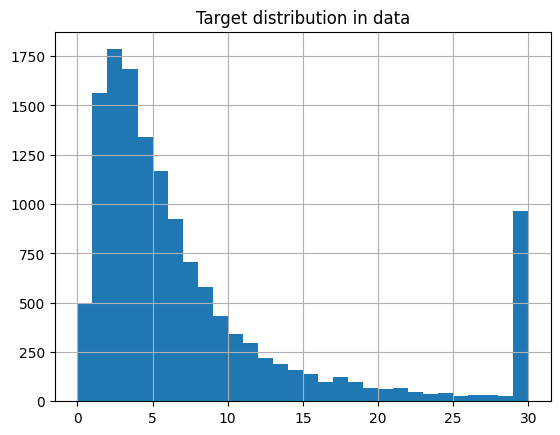

In [87]:
data['y'].hist(bins=30);
plt.title("Target distribution in data");

### Months distribution:

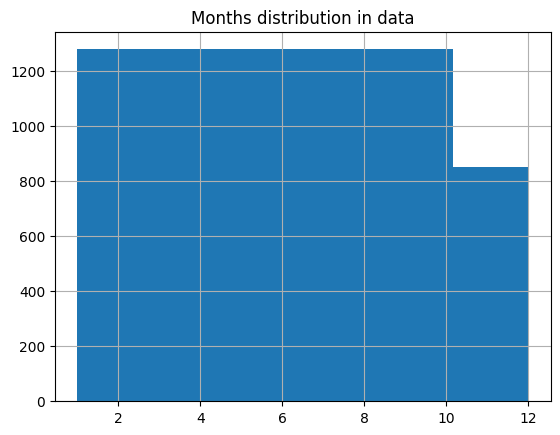

In [88]:
data['ds'].dt.month.hist(bins=12);
plt.title("Months distribution in data");

### Target differences and log differences:

In [89]:
log_diff_df = data.copy()
log_diff_df['y'] = log_diff_df.groupby('unique_id')['y'].transform(lambda series: np.log1p(series).diff())

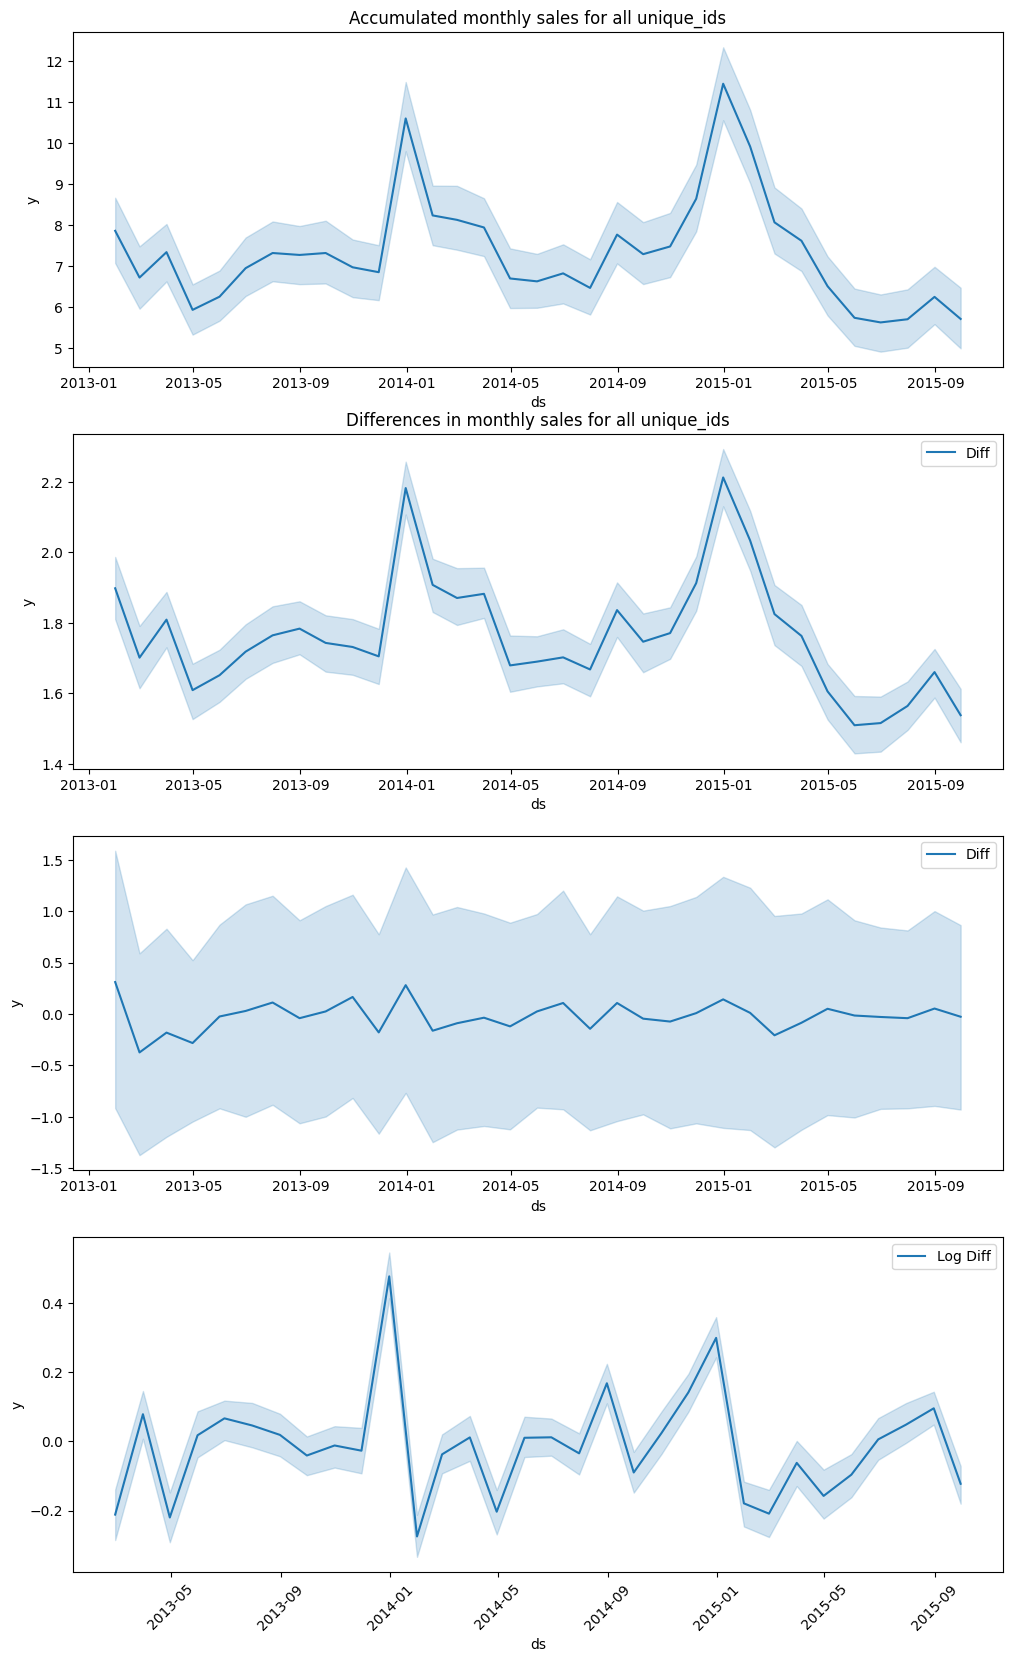

In [90]:
fig = plt.figure(figsize = (12, 20))
ax1, ax2, ax3, ax4 = fig.subplots(4, 1)

sns.lineplot(data = data, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for all unique_ids
plt.xticks(rotation=45);
ax1.set_title("Accumulated monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].apply(np.log1p), ax=ax2, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Accumulated LOG monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].diff(), ax=ax3, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Differences in monthly sales for all unique_ids");

sns.lineplot(data = log_diff_df, x = "ds", y = 'y', ax=ax4, label='Log Diff');
plt.xticks(rotation=45);
ax2.legend()

### Random samples sales patterns:

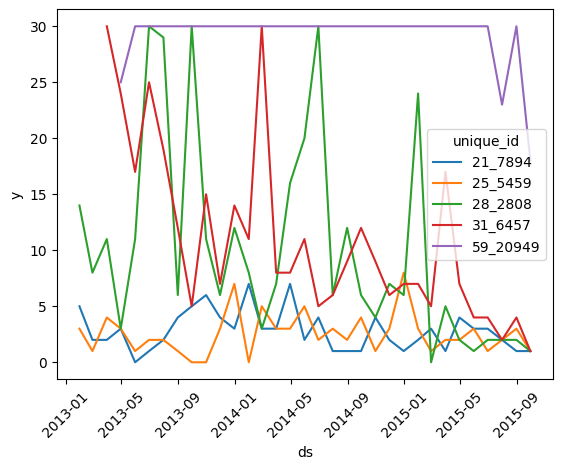

In [91]:
# sample 10 unique_ids to plot

sample_ids = random.sample(list(data["unique_id"].unique()), 5)
sns.lineplot(data = data[data['unique_id'].isin(sample_ids)], x = "ds", 
             y = "y", hue = "unique_id", legend = True);
plt.xticks(rotation=45);

### Clusters capturing target dispersion:

There are some TS quite constant and others with high dispersion.

It seems to be some seasonality around January

In [92]:
desc_stats = data.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])
kmeans = KMeans(n_clusters=3, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_
data2 = data.merge(desc_stats[['cluster']], on='unique_id')
data2.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,9.496714,7.472434,0.000000,4.000000,7.000000,13.000000,30.000000
1,4.027693,3.161066,0.000000,2.000000,3.000000,5.000000,23.000000
2,27.734542,6.072042,0.000000,30.000000,30.000000,30.000000,30.000000


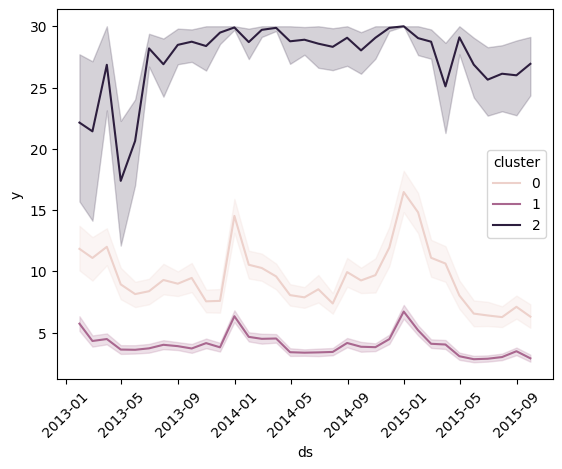

In [93]:
sns.lineplot(x='ds', y='y', hue='cluster', data=data2)
plt.xticks(rotation=45);

# NaN imputation:

NaN imputation with KNNimputer.

<Axes: xlabel='unique_id', ylabel='ds'>

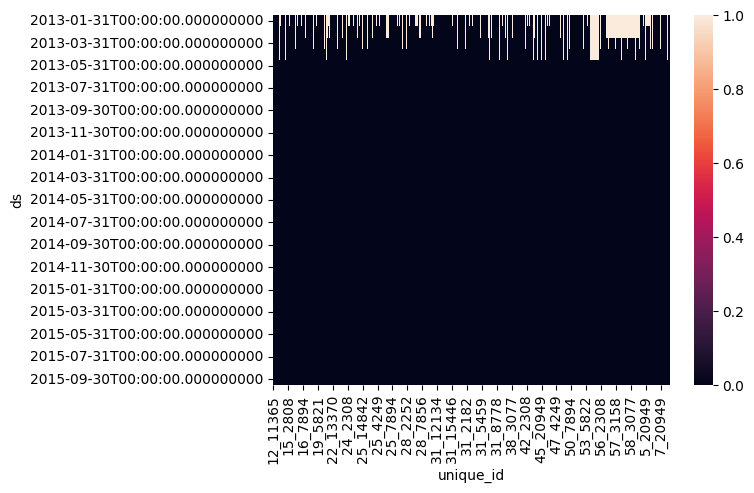

In [94]:
pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="y").isnull()

sns.heatmap(pivot_df)

<Axes: xlabel='unique_id', ylabel='ds'>

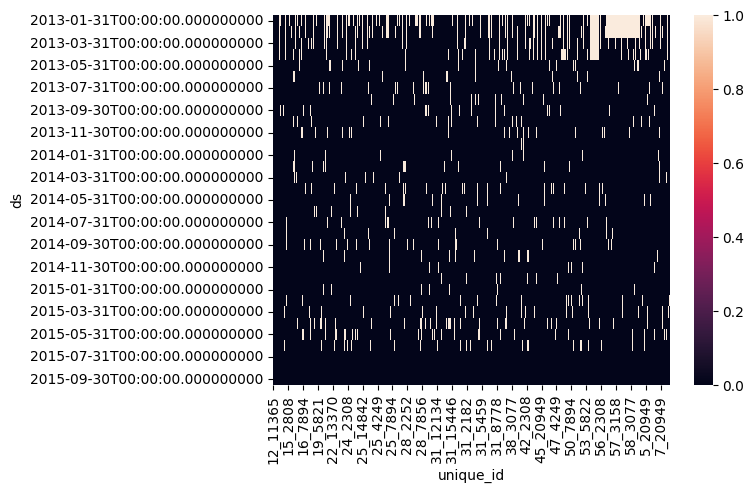

In [95]:
pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="monthly_average_price").isnull()

sns.heatmap(pivot_df)

### KNN imputation:

In [96]:
# Create a copy of the original data to avoid modifications
data_temp = data.copy()

# Extract time-based features from the 'ds' column because KNN needs numeric features
data_temp['month'] = data_temp['ds'].dt.month
data_temp['year'] = data_temp['ds'].dt.year
data_temp['quarter'] = data_temp['ds'].dt.quarter
data_temp['around_Xmas'] = data_temp['ds'].dt.month.isin([1,12])

# Transformar 'month' en sus representaciones seno y coseno
data_temp['month_sin'] = np.sin(2 * np.pi * data_temp['month'] / 12)
data_temp['month_cos'] = np.cos(2 * np.pi * data_temp['month'] / 12)

# Columns to impute using KNN
cols_with_missing = ['monthly_average_price', 'y']

# Drop unnecessary columns and create a copy for imputation
data_impute = data_temp.drop(columns=['ds', 'unique_id']).copy()

# Fit and transform the KNN imputer
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(data_impute)

# Create a DataFrame with the imputed values
imputed_df = pd.DataFrame(imputed_values, columns=data_impute.columns, index=data_impute.index)

# Merge the imputed columns with the original data, excluding the imputed ones
data_final = imputed_df[cols_with_missing].merge(
    data_temp.drop(columns=cols_with_missing), how='right', left_index=True, right_index=True
)

data = data_final.copy()

In [97]:
# replace imputed values in target to 0 for date 2015-10-31 (test data)
test_index = [sorted(list(data["ds"].unique()))[-1]]
data['y'] = np.where(data['ds'].isin(test_index), 0, data['y'])

# Simple engineering for analysis:

### Revenue

In [98]:
data["revenue"] = (data["y"] * data["monthly_average_price"])

# Sales and Revenue analysis by shop, city, item, and category

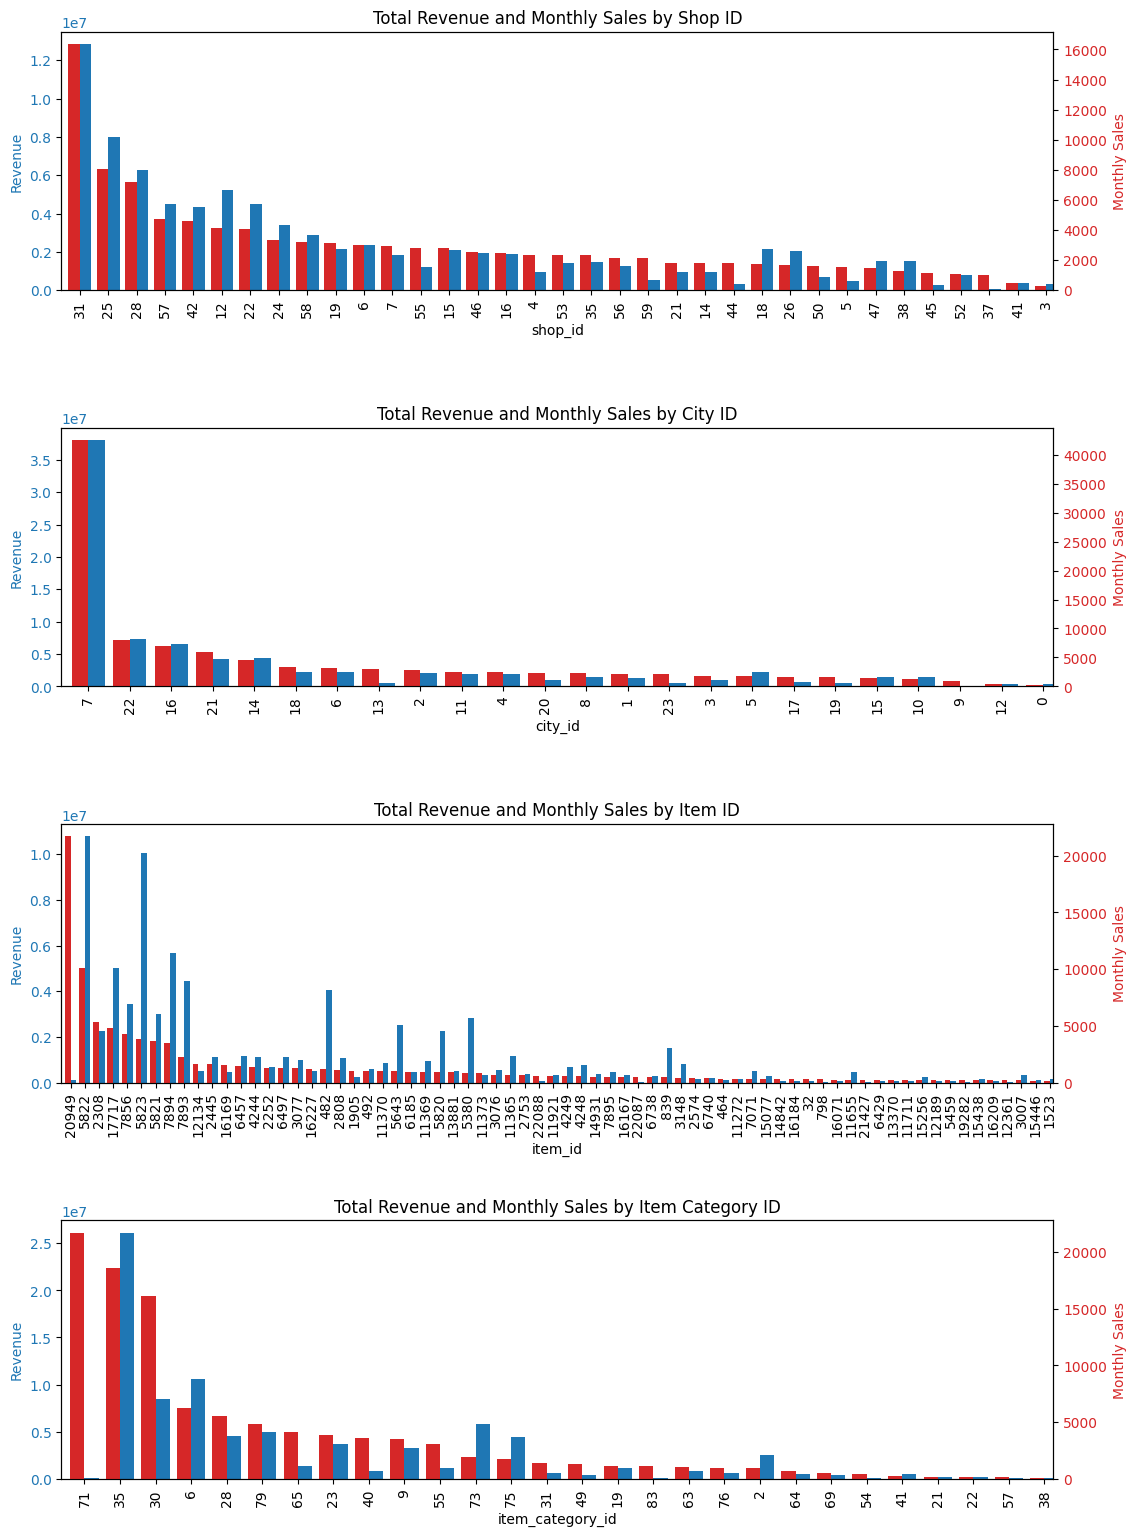

In [99]:
# Group data by different categories and calculate sums
grouped_shop = data.groupby("shop_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)
grouped_city = data.groupby("city_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)
grouped_item = data.groupby("item_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False).head(70)
grouped_category = data.groupby("item_category_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)

# Create a figure with 4 subplots, one for each grouping
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

# Function to plot data on primary and secondary y-axes
def plot_grouped_data(ax, grouped_data, title):
    color = 'tab:blue'
    ax.set_xlabel('ID')
    ax.set_ylabel('Revenue', color=color)
    grouped_data['revenue'].plot(kind='bar', ax=ax, color=color, position=0, width=0.4)
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Monthly Sales', color=color)  
    grouped_data['y'].plot(kind='bar', ax=ax2, color=color, position=1, width=0.4)
    ax2.tick_params(axis='y', labelcolor=color)

    ax.set_title(title)
    ax.figure.tight_layout()  # Ensure the plot fits into the figure area

# Plot each grouped DataFrame on separate subplots
plot_grouped_data(axs[0], grouped_shop, 'Total Revenue and Monthly Sales by Shop ID')
plot_grouped_data(axs[1], grouped_city, 'Total Revenue and Monthly Sales by City ID')
plot_grouped_data(axs[2], grouped_item, 'Total Revenue and Monthly Sales by Item ID')
plot_grouped_data(axs[3], grouped_category, 'Total Revenue and Monthly Sales by Item Category ID')

plt.tight_layout(pad=3.0)
plt.show()

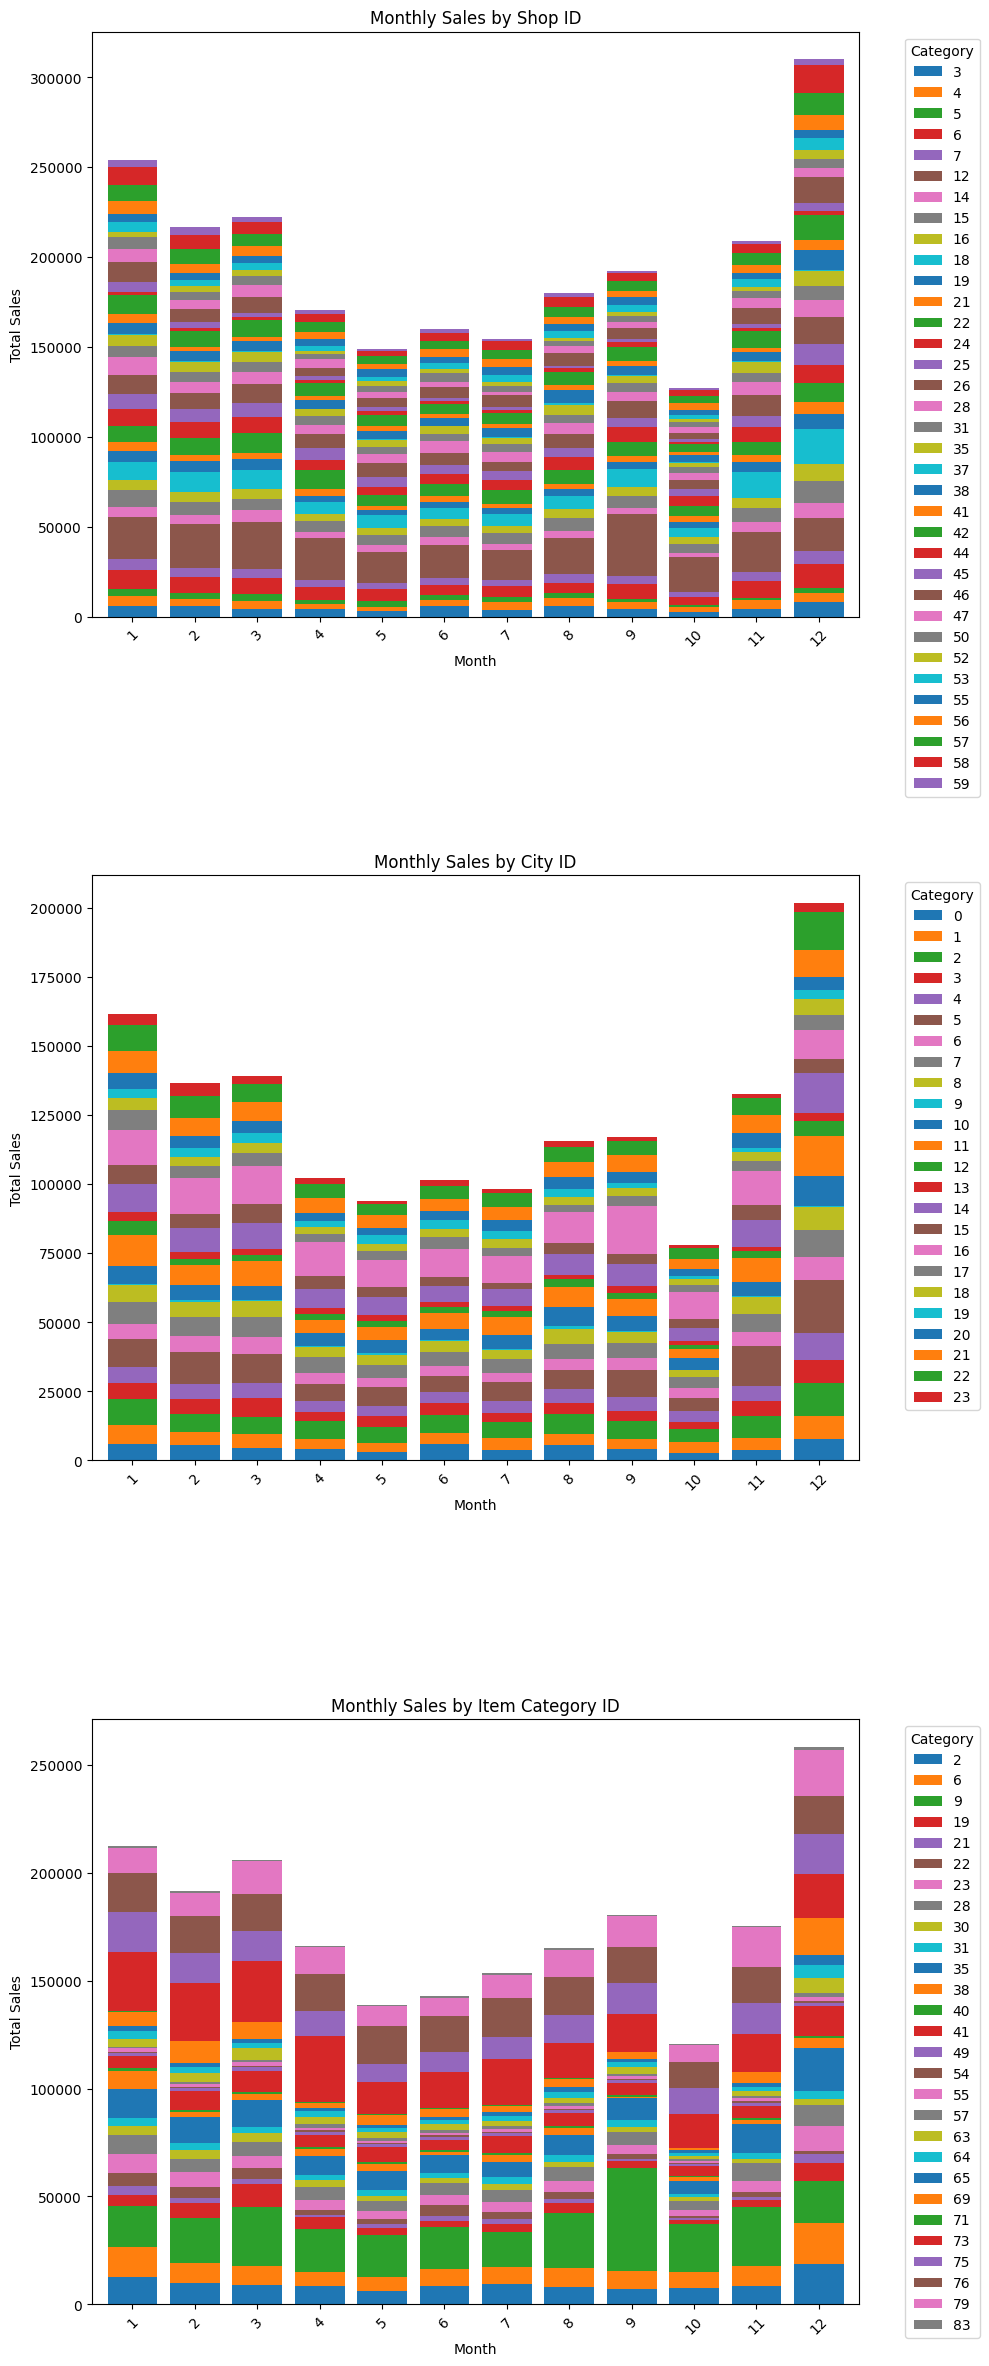

In [100]:
# Group data by different categories and calculate sums for each month
grouped_shop_month = data.groupby(["month", "shop_id"])["revenue"].mean().unstack(fill_value=0)
grouped_city_month = data.groupby(["month", "city_id"])["revenue"].mean().unstack(fill_value=0)
grouped_category_month = data.groupby(["month", "item_category_id"])["revenue"].mean().unstack(fill_value=0)

# Create a figure with 3 subplots, one for each grouping
fig, axs = plt.subplots(3, 1, figsize=(10, 24))  # Reduced width, increased height

# Function to plot data
def plot_grouped_data(ax, grouped_data, title):
    grouped_data.plot(kind='bar', stacked=True, ax=ax, width=0.8)  # Reduced bar width
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Sales')
    ax.set_title(title)
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)  # Moved legend to the right
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Plot each grouped DataFrame on separate subplots
plot_grouped_data(axs[0], grouped_shop_month, 'Monthly Sales by Shop ID')
plot_grouped_data(axs[1], grouped_city_month, 'Monthly Sales by City ID')
plot_grouped_data(axs[2], grouped_category_month, 'Monthly Sales by Item Category ID')

plt.tight_layout()
plt.show()

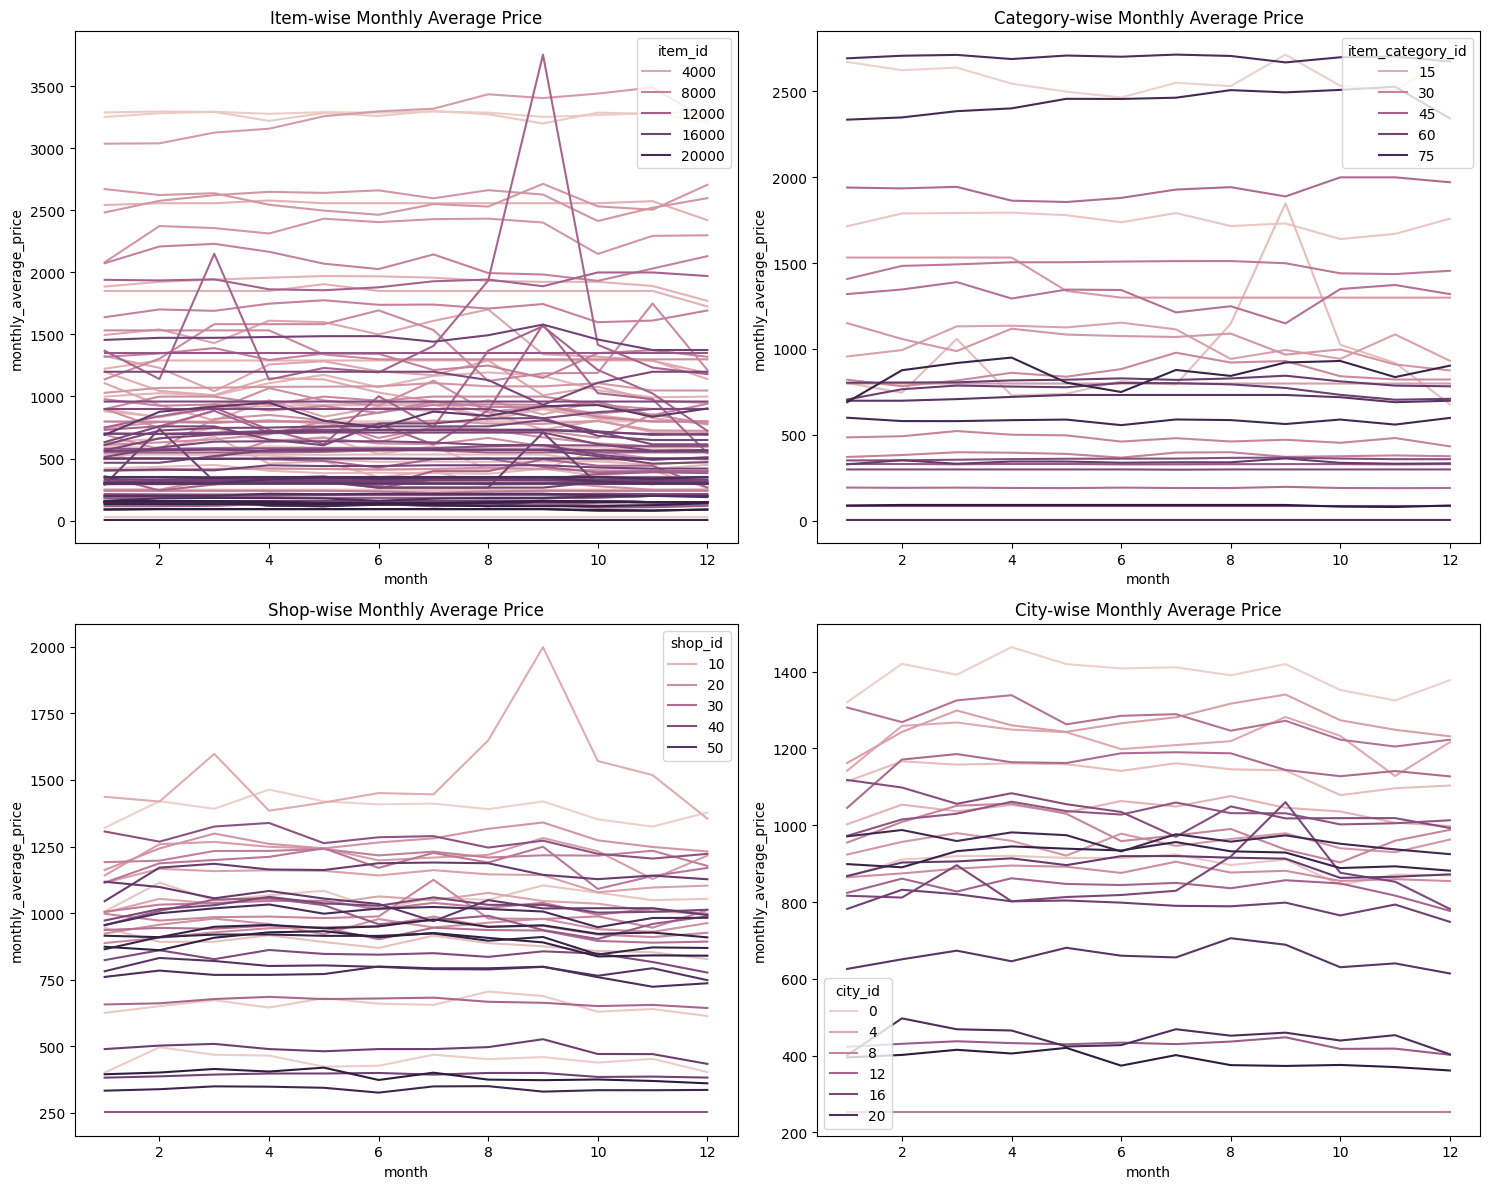

In [101]:
# Prepare the data
plot_data_item = data.groupby(['item_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_city = data.groupby(['city_id','month'])['monthly_average_price'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise Monthly Average Price')

# Plot 2: Category-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise Monthly Average Price')

# Plot 3: Shop-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise Monthly Average Price')

# Plot 4: City-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise Monthly Average Price')

# Adjust the layout
plt.tight_layout()
plt.show()

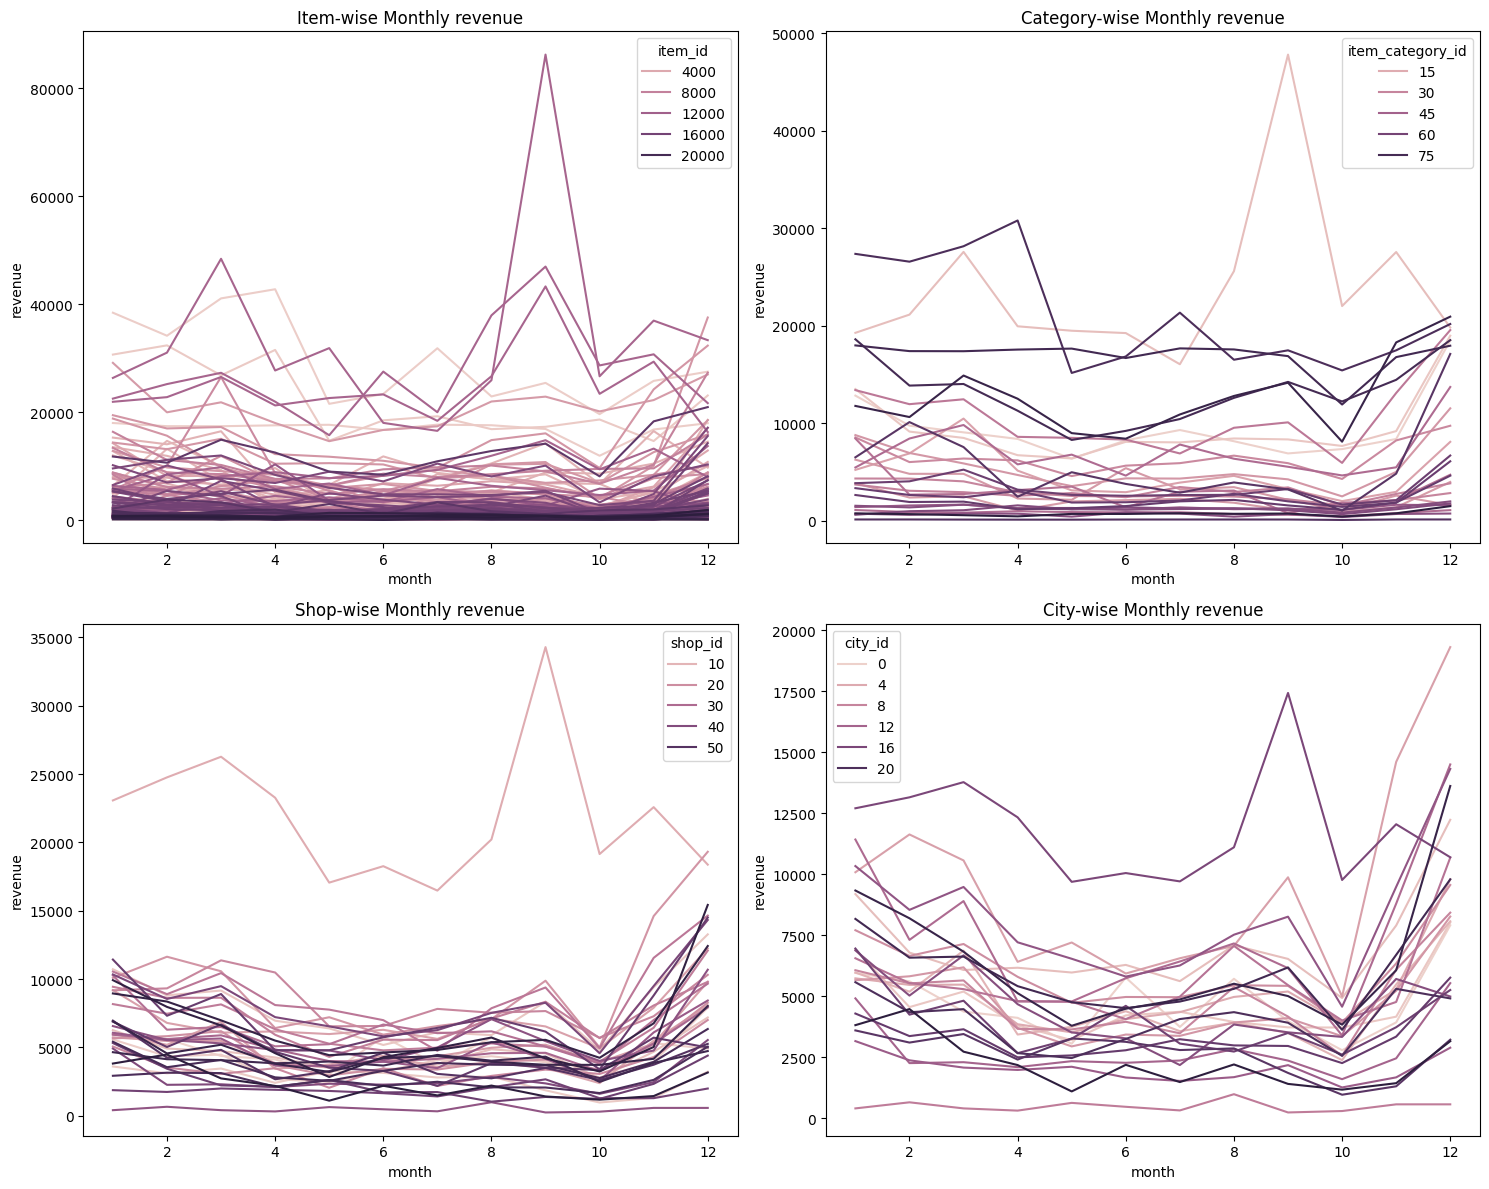

In [102]:
# Prepare the data
plot_data_item = data.groupby(['item_id','month'])['revenue'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','month'])['revenue'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','month'])['revenue'].mean().reset_index()
plot_data_city = data.groupby(['city_id','month'])['revenue'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise Monthly revenue
sns.lineplot(x='month', y='revenue', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise Monthly revenue')

# Plot 2: Category-wise Monthly revenue
sns.lineplot(x='month', y='revenue', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise Monthly revenue')

# Plot 3: Shop-wise Monthly revenue
sns.lineplot(x='month', y='revenue', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise Monthly revenue')

# Plot 4: City-wise Monthly revenue
sns.lineplot(x='month', y='revenue', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise Monthly revenue')

# Adjust the layout
plt.tight_layout()
plt.show()

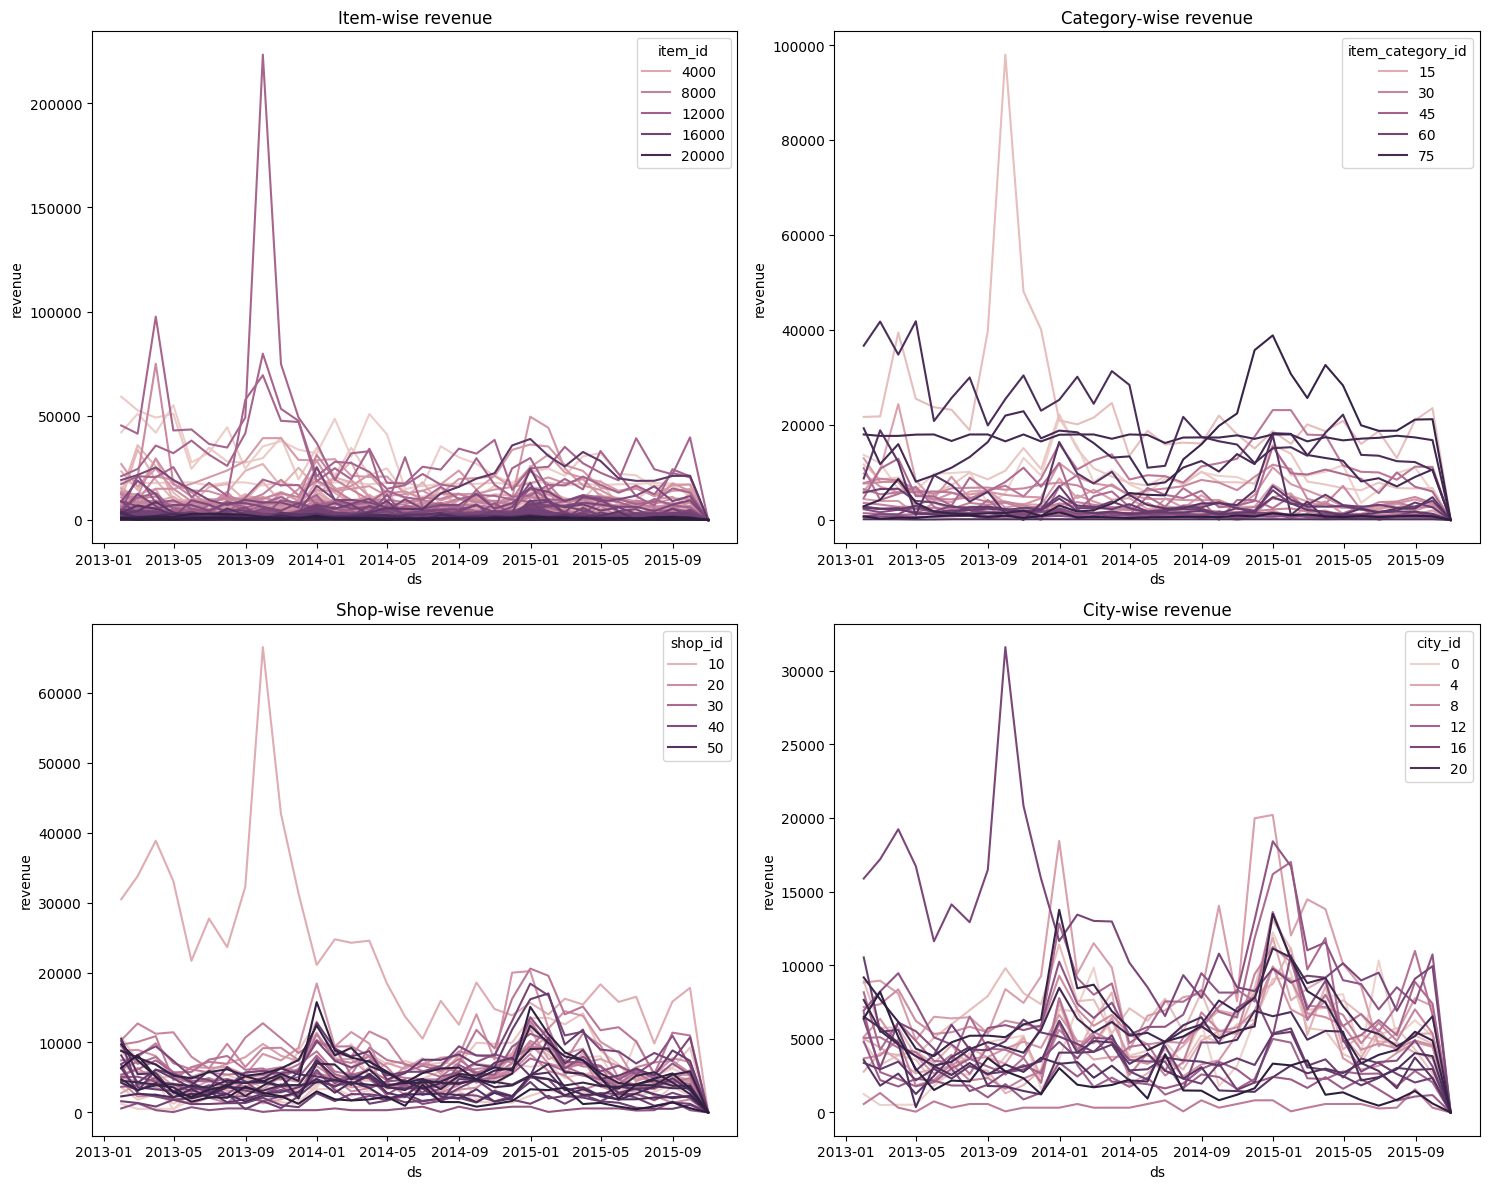

In [103]:
# Prepare the data
plot_data_item = data.groupby(['item_id','ds'])['revenue'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','ds'])['revenue'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','ds'])['revenue'].mean().reset_index()
plot_data_city = data.groupby(['city_id','ds'])['revenue'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise revenue
sns.lineplot(x='ds', y='revenue', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise revenue')

# Plot 2: Category-wise revenue
sns.lineplot(x='ds', y='revenue', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise revenue')

# Plot 3: Shop-wise revenue
sns.lineplot(x='ds', y='revenue', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise revenue')

# Plot 4: City-wise revenue
sns.lineplot(x='ds', y='revenue', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise revenue')

# Adjust the layout
plt.tight_layout()
plt.show()

# Save full features data:

In [104]:
data.head()

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,quarter,around_Xmas,month_sin,month_cos,revenue
0,1511.512626,30.0,2013-01-31,12_11365,16,12,9,11365,1,2013,1,True,0.5,0.866025,45345.378788
1,572.715278,30.0,2013-01-31,12_11369,16,12,9,11369,1,2013,1,True,0.5,0.866025,17181.458333
2,699.776786,30.0,2013-01-31,12_11370,16,12,9,11370,1,2013,1,True,0.5,0.866025,20993.303571
3,548.900000,6.0,2013-01-31,12_11373,16,12,9,11373,1,2013,1,True,0.5,0.866025,3293.400000
4,350.000000,3.0,2013-01-31,12_12231,16,12,49,12231,1,2013,1,True,0.5,0.866025,1050.000000


In [105]:
data.shape

(14484, 15)

In [106]:
data.to_pickle('./data/KNN_imputed_data_15f.pkl')